# Computer Assignment 7
## Group 3



## Part a)

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
#import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from random import randint

Using TensorFlow backend.


In [2]:
# Preparing the dataset
#Divide the training data set into 10 data sets
N = 60000
M = 10000
num_workers = 10 #Number of workers
num_classes = 10 #Number of output classes
image_size = 784
numSamples = N//num_workers #Number of training samples per worker

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size).T
x_test = x_test.reshape(x_test.shape[0], image_size).T

X = {}
Y = {}

for idx in range(num_workers):
    X[idx] = x_train[:,idx*numSamples:(idx+1)*numSamples]
    Y[idx] = y_train[idx*numSamples:(idx+1)*numSamples]

# Data processing
x_train is of size 784x60000 contaning 60000 examples each with 784 features. y_train is of size 60000x1 and each y value is the number in the corresponding example image. We have divided the data set into 10 data sets. X is a list containing 10 ndarrays of size 784x6000 and Y is a list containing 10 ndarrays of size 6000x1.

# One-versus-rest (soft-margin) SVM
We first describe the binary-class SVM and describe how it is applied for the case of multi class. The binary-class SVM classifies an input example $i$ into a postive example or a negative example indicated, respectively, by $t_i = 1$ and $t_i = -1$ in the training set. The weigth vector $\mathbf{w}$ is trained by minimizing the following function.
$$ f(\mathbf{w}) = \frac{1}{N} \sum_{i\in [N]} \max(0, 1 - t_i \mathbf{w}^T x_i) + \frac{\lambda}{2} ||\mathbf{w}||_2^2, $$
The subgradient of the above function is given by:
$$ \frac{\partial f(\mathbf{w})}{\partial \mathbf{w}} = \frac{1}{N} \sum_{i\in[N]} -t_i x_i \mathbb{1}(t_i \mathbf{w}^T x_i < 1) + \lambda \mathbf{w} $$,
where $\mathbb{1}(\cdot)$ is an indicator function.

For each class $j$, one-versus-rest SVM calls the binary-class SVM by treating all examples of class $j$ are assigned $t_i = 1$ and the rest of the examples are assigned $t_i = -1$. Therefore, for each class $j$, a weight vector $\mathbf{w}_j$ is tranined. For MNIST data set we have 10 classes and thus we train 10 $\mathbf{w}_j$ vectors, which forms the columns of the weight matrix $w_k$ of size $784$x$10$. 

For the test data classification is done as follows. Given test example $\mathbf{x}_i$, we multiply with weight matrix $\mathbf{w}_k$, which results in a vector of size $10$ (a row of the 'socres' variable below). Note that the value of element $j$ of this vector indicates whether the example belongs to class $j$ (if the value is positive) or the not (if the value is negative). We out put $j$, where the value in the vector is the highest. 



In [40]:
#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    #print(np.max(scores, axis = 1))
    #print(scores)
    #class_votes = np.zeros(scores.shape)
    #class_votes[scores > 0] += 1
    #for i in range(10):
    #    class_votes[scores[:,i] <= 0,:] += 1
    #class_votes[scores <= 0] -= 1
    #return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
    #return np.argmax(class_votes, axis = 1)
    return np.argmax(scores, axis = 1)

def bin_SVM_classification_err(x,y,w):
    y_estimate = bin_SVM_classify(x, w)
    #print(y_estimate)
    return sum(y_estimate != y)*100.0/len(y)
            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w) 
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = bin_SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi).sum(axis = 1) + lambda_ * w[:, i]
    return svm_cost_grad

# Quantization
We use a simple uniform quantization technique. At each node, in each iteration, it computes the minimum and maximum values of the local gradient ('gf' is the variable name in the code), and divides the range between these values into $2^{\text{Num Bits}}$ bins. All the values in each bin are replaced by the minimum value in the bin. Then the node can send the minimum and maximum values without quantization and all other values of the gradient can be encoded into $\text{Num Bits}$. 

In our implementation, we only quantize the gradient values and leave out the details on how they can be stored in a byte stream (for transmission), with $\text{Num Bits}$ per value, as this is not required for studying the effect of quantization on the classification error.


# Compression
Each node sends its gradient by only keeping $K$ values non-zeros and setting all other values to zero. In our implementation, the gradient at each node is of dimension $784$x$10$. For each node we select rows randomly from gf and set all the values of these rows equal to zero, and make sure that only $K$ values in gf are not changed. 

We compute test errors for different K values which result in to $50$\%, $25$\%, and $10$\% of $7840$ values being non-zero. They correspond to $50$\%, $75$\%, and $90$\% compression in the gradient.


In [ ]:
#If QUANTIZATION is 1, then gradient is quantized based on numBits, else it is compressed based on K value
QUANTIZATION = 1
numBits = 1
K = 784*10*0.25
numZeros = int((784*10 - K)//10)

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data.
#x dimension is 6000x684
#y dimension is 6000. 
#w dimension is 784x10. Each column of w is trained for one calss vs the rest
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
  
    ## compute the gradients ----------------------------------------
    return bin_SVM_cost_grad(x, y, w_k, lambda_) #train the weights for class i
        

#Distributed Gradient Descent
def decentralized_gradient_descent(x,y,lambda_,learn_rate,max_iter):
    #each class has a w_k
    w_k = np.random.rand(image_size, 10)
    #w_k = w
    T = 0
    itr = 0
    err_test = []
    err_train = []
    #L1 = regulated_total_cost(x_train, y, w_k, lambda_)
    while 1:
        workers_w_k = np.array(10 * [w_k]).reshape(10, image_size, 10)
        grad_w = np.zeros([image_size,num_classes])
        for idx in range(num_workers):
            gf = decentralized_gradient_descent_worker(X[idx],Y[idx],workers_w_k[idx,:,:],lambda_)
            
            gf = gf/numSamples
            #print(len(gf[gf < 1]))
            #print(np.nonzero(gf > 134))
            #print(gf[407][0])
            
            if QUANTIZATION:
            #Quantize the values in gf. The resulting gf can be communicated using 4 bits per value.
                minVal = gf.min()
                maxVal = gf.max()
                quantizationErr = (maxVal-minVal)*1.0/pow(2,numBits)
                gf = minVal + ((gf-minVal)//quantizationErr)*quantizationErr
                print(minVal,maxVal,quantizationErr)
                print(gf[401:410])
            else:
            #Do compression by sending only K values of the gradient
                gf[np.random.randint(gf.shape[0], size=numZeros), :] = 0 #This step replaces randomly selected rows (each row contains 10 elements) with zeros
            
            
            grad_w = grad_w + gf
            
        #print('w_k',w_k.shape)
        w_k = w_k - learn_rate*grad_w*numSamples/N
        
        err_test.append(bin_SVM_classification_err(x_test,y_test,w_k))
        err_train.append(bin_SVM_classification_err(x_train,y_train,w_k))
        
        #print('norm:',np.linalg.norm(w_k,axis=0))
        print(itr)
        itr = itr + 1
        if itr >= max_iter:
            break        
        
    #print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(image_size,10), err_test, err_train

#Intialize the parameters
max_iter = 10
lambda_ = 1
learn_rate = 0.005

start = time.time() 
w, err_test, err_train = decentralized_gradient_descent(x_train,y_train,lambda_,learn_rate,max_iter)  
end = time.time()
print('time=',end-start,' seconds')
#np.savetxt('w100_quantized_1bits_star.csv',w,delimiter=',')
#np.savetxt('err_test_100_quantized_1bits_star.csv',err_test,delimiter=',')
#np.savetxt('err_train_100_quantized_1bits_star.csv',err_train,delimiter=',')
#err_test
#err_train

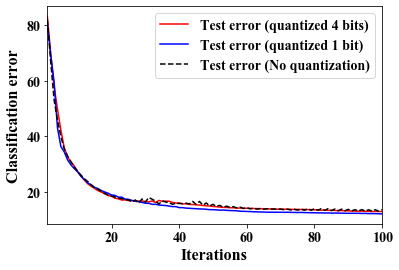

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)

err_test = pd.read_csv("err_test_100_quantized_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Test error (quantized 4 bits)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_test = pd.read_csv("err_test_100_quantized_1bits_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-b',label = 'Test error (quantized 1 bit)')

err_test = pd.read_csv("err_test_100_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Test error (No quantization)')
#plt.plot(list(range(1,Iterations+1)),err_train,'--b',label ='Training error')

legend()

# Observation
We found that the test error (also we checked for training error, see figure below) is not higher when we used quantization, suprisingly, even for 1 bit quantization, where all the values in the interval $[\texttt{minValue}, \texttt{minValue} + \texttt{quantizationErr})$ take $\texttt{minValue}$ and all the values in the interval $[\texttt{minValue} + \texttt{quantizationErr}, \texttt{maxValue})$ take $\texttt{minValue} + \texttt{quantizationErr}$. 

We don't have a clear explanation for this result. However, we have printed out observed the values in 'scores' variable (from bin_SVM_classify function) while doing classification using 'w' with no quantization and with 1 bit quantization. In both the cases, we did find that the maximum values in scores variables are occuring at same indices for almost all the examples, and thus both 'w' result in similar test error.

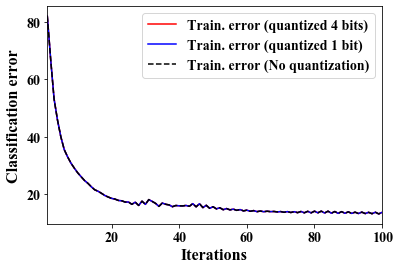

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)

err_train = pd.read_csv("err_train_100_quantized_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Train. error (quantized 4 bits)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_train = pd.read_csv("err_train_100_quantized_1bits_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-b',label = 'Train. error (quantized 1 bit)')

err_train = pd.read_csv("err_train_100_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Train. error (No quantization)')
#plt.plot(list(range(1,Iterations+1)),err_train,'--b',label ='Training error')

legend()

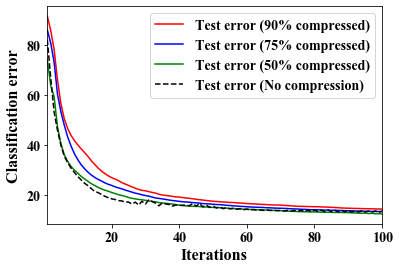

In [86]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100
err_test_50 = pd.read_csv("err_test_100_compress_K_half_star.csv", delimiter=",", header=None).values
err_test_75 = pd.read_csv("err_test_100_compress_K_25percent_star.csv", delimiter=",", header=None).values
err_test_90 = pd.read_csv("err_test_100_compress_K_10percent_star.csv", delimiter=",", header=None).values

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)
plt.plot(list(range(1,Iterations+1)),err_test_90,'-r',label = 'Test error (90% compressed)')
plt.plot(list(range(1,Iterations+1)),err_test_75,'-b',label = 'Test error (75% compressed)')
plt.plot(list(range(1,Iterations+1)),err_test_50,'-g',label = 'Test error (50% compressed)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_test = pd.read_csv("err_test_100_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Test error (No compression)')
#plt.plot(list(range(1,Iterations+1)),err_train,'--b',label ='Training error')

legend()

# Observation
As expected, as we increase compression by introducing more zeros in the gradient results in higher test error.

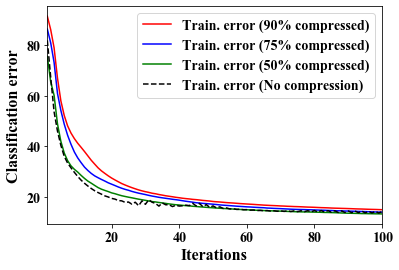

In [36]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100
err_train_50 = pd.read_csv("err_train_100_compress_K_half_star.csv", delimiter=",", header=None).values
err_train_75 = pd.read_csv("err_train_100_compress_K_25percent_star.csv", delimiter=",", header=None).values
err_train_90 = pd.read_csv("err_train_100_compress_K_10percent_star.csv", delimiter=",", header=None).values

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)
plt.plot(list(range(1,Iterations+1)),err_train_90,'-r',label = 'Train. error (90% compressed)')
plt.plot(list(range(1,Iterations+1)),err_train_75,'-b',label = 'Train. error (75% compressed)')
plt.plot(list(range(1,Iterations+1)),err_train_50,'-g',label = 'Train. error (50% compressed)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_train = pd.read_csv("err_train_100_star.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_train,'--k',label = 'Train. error (No compression)')
#plt.plot(list(range(1,Iterations+1)),err_train,'--b',label ='Training error')

legend()

# Two-star Communication Graph
For this network, we use the following (double stochastic) transition matrix.  

  
$$A = 
\begin{pmatrix}
5/6 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 5/6 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 5/6 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 5/6 & 1/6 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 0 & 1/6 & 5/6 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 5/6 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 5/6 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 5/6
\end{pmatrix}$$

Number of signalling exchanges per iteration of decentralized sub-gradient algorithm is equal to 
$$2\sum_i \text{deg}(\text{Node } i) = \text{Number of non-zero non-diagonal elements of }A,$$
which equals 18 for two-start communication graph.

In [38]:
A = np.identity(10)*(5/6)
A[4,0:6]  = 1/6
A[5,5:10] = 1/6
A[0:6,4]  = 1/6
A[5:10,5] = 1/6

In [ ]:
#If QUANTIZATION is 1, then gradient is quantized based on numBits, else it is compressed based on K value
QUANTIZATION = 0
numBits = 1
K = 784*10*0.25
numZeros = int((784*10 - K)//10)

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data.
#x dimension is 6000x684
#y dimension is 6000. 
#w dimension is 784x10. Each column of w is trained for one calss vs the rest
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    
    ## compute the gradients ----------------------------------------
    return bin_SVM_cost_grad(x, y, w_k, lambda_) #train the weights for class i


#Distributed Gradient Descent
def decentralized_gradient_descent(x,y,lambda_,learn_rate,max_iter):
    #each class has a w_k
    workers_w_k_new = np.random.rand(10,image_size, 10)
    workers_w_k_prev = np.random.rand(10,image_size, 10)
    #w_k = w
    T = 0
    itr = 0
    err_test_node1 = []
    err_test_node5 = []
    errLocal_train_node1 = []
    errLocal_train_node5 = []    

    while 1:
        grad_w = np.zeros([image_size,num_classes])
        for idx in range(num_workers):
            #Worker idx first performs consensus step using communication matrix A and then updates its gradient
            #Quantization or Compression: workers_w_k_prev contains quantized/compressed gradients and workers_w_k_new contains actual gradients 
            #from the previous time step.
            
            #Each node has access to its own gradient and quantized/compressed gradients from its neighbours.
            w_k = workers_w_k_prev #quantized gradients from previous time step
            w_k[idx,:,:] = workers_w_k_new[idx,:,:] #actual gradient of idx from the previous time step
            
            #Step 1: Consensus 
            workers_w_k_new[idx,:,:] = np.average(w_k,axis=0,weights=A[idx,:])
            
            #Step 2: Update gradient
            gf = decentralized_gradient_descent_worker(X[idx],Y[idx],workers_w_k_new[idx,:,:],lambda_)

            workers_w_k_new[idx,:,:] = workers_w_k_new[idx,:,:] - learn_rate*gf/numSamples
        
        #Compute classification error using test data for Node 1 and Node 5
        err_test_node1.append(bin_SVM_classification_err(x_test,y_test,workers_w_k_new[0,:,:]))
        
        err_test_node5.append(bin_SVM_classification_err(x_test,y_test,workers_w_k_new[4,:,:]))
        
        #Compute classification error using training data at Node 1 and Node 5
        errLocal_train_node1.append(bin_SVM_classification_err(X[0],Y[0],workers_w_k_new[0,:,:]))
        
        errLocal_train_node5.append(bin_SVM_classification_err(X[4],Y[4],workers_w_k_new[4,:,:]))        

        #Emulating exchange of weights between neighbours. 
        #Number of signalling exchanges this requires is equal to 2*(\sum_i deg(Node i)) = 18 for two-start communication graph
        if QUANTIZATION:
            #Each node quantizes its gradient before sending it to its neighbours.
            #The resulting gradient can be communicated using numBits bits per value.
            for idx in range(num_workers):
                gf = workers_w_k_new[idx,:,:]
                minVal = gf.min()
                maxVal = gf.max()
                quantizationErr = (maxVal-minVal)*1.0/pow(2,numBits)
                gf = minVal + ((gf-minVal)//quantizationErr)*quantizationErr
                #print(minVal,maxVal,quantizationErr)
                workers_w_k_prev[idx,:,:] = gf
        else:
            #Do compression by sending only K values of the gradient
            for idx in range(num_workers):
                gf = workers_w_k_new[idx,:,:]
                gf[np.random.randint(gf.shape[0], size=numZeros), :] = 0 #This step replaces randomly selected rows (each row contains 10 elements) with zeros
                workers_w_k_prev[idx,:,:] = gf
        
        #print('norm:',np.linalg.norm(w_k,axis=0))
        print(itr)
        itr = itr + 1
        if itr >= max_iter:
            break        
        
    #print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return workers_w_k_new, err_test_node1, err_test_node5, errLocal_train_node1, errLocal_train_node5

#Intialize the parameters
max_iter = 100
lambda_ = 1
learn_rate = 0.005

start = time.time() 
w, err_test_node1, err_test_node5, errLocal_train_node1, errLocal_train_node5 = decentralized_gradient_descent(x_train,y_train,lambda_,learn_rate,max_iter)  
end = time.time()
print('time=',end-start,' seconds')
np.savetxt('w100_twoStar_compress_75percent.csv',w[0,:,:],delimiter=',')
np.savetxt('w100_twoStar_compress_75percent_Node5.csv',w[4,:,:],delimiter=',')
np.savetxt('errTest_100_compress_75percent_Node1.csv',err_test_node1,delimiter=',')
np.savetxt('errTest_100_compress_75percent_Node5.csv',err_test_node5,delimiter=',')
np.savetxt('errTrain_100_compress_75percent_Node1.csv',errLocal_train_node1,delimiter=',')
np.savetxt('errTrain_100_tcompress_75percent_Node5.csv',errLocal_train_node5,delimiter=',')
#errs1
#errs5

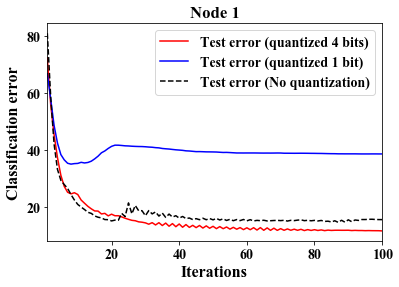

In [66]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

ax = plt.subplot(111)
plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)


plt.title('Node 1')
err_test = pd.read_csv("errTest_100_twoStar_quantize_4bits_Node1.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Test error (quantized 4 bits)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_test = pd.read_csv("errTest_100_twoStar_quantize_1bits_Node1.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-b',label = 'Test error (quantized 1 bit)')

err_test = pd.read_csv("../CA5/errTest_100_twoStar_Node1.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Test error (No quantization)')

legend()


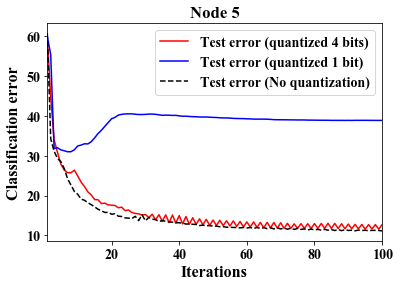

In [65]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

ax = plt.subplot(111)
plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)

plt.title('Node 5')
err_test = pd.read_csv("errTest_100_twoStar_quantize_4bits_Node5.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Test error (quantized 4 bits)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_test = pd.read_csv("errTest_100_twoStar_quantize_1bits_Node5.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-b',label = 'Test error (quantized 1 bit)')

err_test = pd.read_csv("../CA5/errTest_100_twoStar_Node5.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Test error (No quantization)')

legend()

# Observation
In contrast to star topolgy, the classification error is quite high for 1 bit quantization.

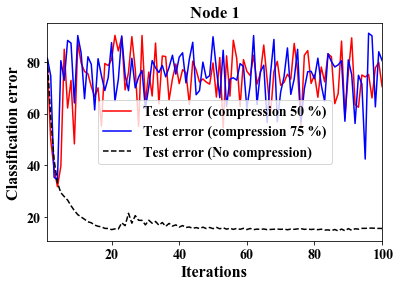

In [67]:
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)

plt.title('Node 1')
err_test = pd.read_csv("errTest_100_compress_50percent_Node1.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Test error (compression 50 %)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_test = pd.read_csv("errTest_100_compress_75percent_Node1.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-b',label = 'Test error (compression 75 %)')

err_test = pd.read_csv("../CA5/errTest_100_twoStar_Node1.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Test error (No compression)')

legend()


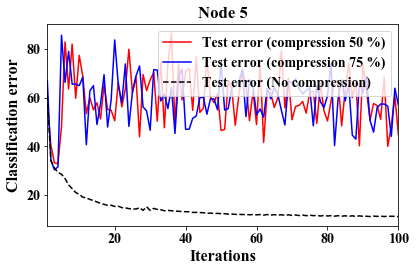

In [68]:
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)

plt.title('Node 5')
err_test = pd.read_csv("errTest_100_compress_50percent_Node5.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Test error (compression 50 %)')
#plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error (quantized grad.)')

err_test = pd.read_csv("errTest_100_compress_75percent_Node5.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'-b',label = 'Test error (compression 75 %)')

err_test = pd.read_csv("../CA5/errTest_100_twoStar_Node5.csv", delimiter=",", header=None).values
plt.plot(list(range(1,Iterations+1)),err_test,'--k',label = 'Test error (No compression)')

legend()
plt.tight_layout()

# Observation
From the above two figures, we observe that Node 5 is relatively robust to compression when compared to Node 1.

## Part b) 
This part will be completed later.